# Loan Sales Prediction - Data Preparation

This notebook handles:
1. Loading raw data from Excel
2. Data cleaning and preprocessing
3. Feature engineering
4. Converting to ML-ready format
5. Saving processed data for model training

## 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.2f}'.format)

# Set style for plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print("✅ Libraries imported successfully")

✅ Libraries imported successfully


## 2. Load Raw Data

In [2]:
# Define paths
DATA_DIR = Path('../notebooks/data')
RAW_DATA_PATH = DATA_DIR / 'loan_sales.xlsx'
PROCESSED_DATA_PATH = DATA_DIR / 'ml_ready_data.csv'
DASHBOARD_DATA_PATH = Path('../analytics-dashboard/public/data/ml_ready_data.csv')

# Create directories if they don't exist
DATA_DIR.mkdir(parents=True, exist_ok=True)
DASHBOARD_DATA_PATH.parent.mkdir(parents=True, exist_ok=True)

print(f"📂 Data directory: {DATA_DIR.absolute()}")
print(f"📂 Dashboard directory: {DASHBOARD_DATA_PATH.parent.absolute()}")

📂 Data directory: /Users/ismatsamadov/loan_sales_prediction/notebooks/../notebooks/data
📂 Dashboard directory: /Users/ismatsamadov/loan_sales_prediction/notebooks/../analytics-dashboard/public/data


In [3]:
# Load the Excel file
if not RAW_DATA_PATH.exists():
    raise FileNotFoundError(f"❌ Data file not found: {RAW_DATA_PATH}")

df_raw = pd.read_excel(RAW_DATA_PATH)

print(f"✅ Data loaded successfully")
print(f"📊 Shape: {df_raw.shape}")
print(f"\n📋 First few rows:")
df_raw.head()

✅ Data loaded successfully
📊 Shape: (23, 27)

📋 First few rows:


,Rüblər,GDP,Dövlət_Gəlirləri,Dövlət_Xərcləri,Əhalinin_nominal_gəlirləri,Əhalinin_banklardakı_əmanətləri,Orta_aylıq_əməkhaqqı,Xarici_ticarət_dövriyyəsi,İxrac,İdxal,Pul_bazası,Oil_Price,Tikinti-quraşdırma_işlərinə_sərf_edilmiş_vəsait,İstehlak_xərcləri,Yaşayış_evlərinin_tikintisinə_yönəldilmiş_investisiyalar,Mənzil_qiymətləri,Uçot_faiz_dərəcəsi,Kumulyativ_satish,Nağd_pul_kredit_satışı,Portfel,NPLs,ROA,ROE,Net_Interest_Margin,Efficiency_Ratio,Loan-to-Deposit_Ratio,Müştəri_sayı
0,2020 I,17928100.00,7810900.00,5254800.00,13442500.00,8251700.00,0.74,11382010.00,6899110.00,4482900.00,10066900.00,0.09,1963955.70,0.32,288706.60,1.22,0.07,46642841.49,46642841.49,359233.76,25.85,0.00,0.03,0.02,0.77,1.31,25304.00
1,2020 II,16450600.00,4211800.00,6476000.00,13935300.00,7706400.00,0.72,8593330.00,4594080.00,3999250.00,11251800.00,0.05,2030799.30,0.29,337427.20,1.22,0.07,62352225.96,15709384.47,349405.74,37.21,0.01,0.08,0.03,0.71,1.32,16316.00
2,2020 III,17965600.00,5941800.00,6911300.00,14231200.00,7834300.00,0.71,10336170.00,5518370.00,4817800.00,12230100.00,0.07,2206427.10,0.29,316308.80,1.22,0.07,113609773.73,51257547.77,366496.28,37.87,0.02,0.12,0.03,0.71,1.35,32598.00
3,2020 IV,20233800.00,6708600.00,7775000.00,14117100.00,8177900.00,0.71,10830360.00,5888120.00,4942240.00,13564200.00,0.08,3152893.00,0.30,424897.40,1.22,0.06,140001771.45,26391997.72,337946.34,26.70,0.03,0.17,0.03,0.74,1.24,28564.00
4,2021 I,19181900.00,5736400.00,5523700.00,13455900.00,8147500.00,0.71,11962560.00,7660710.00,4301850.00,13315000.00,0.10,1490116.70,0.31,205773.40,1.25,0.06,53293774.11,53293774.11,355393.14,39.61,0.01,0.05,0.03,0.71,1.25,39842.00


## 3. Data Exploration

In [4]:
# Display basic information
print("📊 Dataset Information:")
print(f"  Rows: {df_raw.shape[0]}")
print(f"  Columns: {df_raw.shape[1]}")
print(f"\n📋 Column Names:")
for i, col in enumerate(df_raw.columns, 1):
    print(f"  {i}. {col}")

📊 Dataset Information:
  Rows: 23
  Columns: 27

📋 Column Names:
  1. Rüblər
  2. GDP
  3. Dövlət_Gəlirləri
  4. Dövlət_Xərcləri 
  5. Əhalinin_nominal_gəlirləri
  6. Əhalinin_banklardakı_əmanətləri
  7. Orta_aylıq_əməkhaqqı
  8. Xarici_ticarət_dövriyyəsi
  9. İxrac
  10. İdxal 
  11. Pul_bazası
  12. Oil_Price
  13. Tikinti-quraşdırma_işlərinə_sərf_edilmiş_vəsait
  14. İstehlak_xərcləri
  15. Yaşayış_evlərinin_tikintisinə_yönəldilmiş_investisiyalar
  16. Mənzil_qiymətləri
  17. Uçot_faiz_dərəcəsi
  18. Kumulyativ_satish
  19. Nağd_pul_kredit_satışı
  20. Portfel
  21. NPLs
  22. ROA 
  23. ROE
  24. Net_Interest_Margin
  25. Efficiency_Ratio
  26. Loan-to-Deposit_Ratio
  27. Müştəri_sayı


In [5]:
# Check data types
print("📊 Data Types:")
df_raw.dtypes

📊 Data Types:


Rüblər                                                       object
GDP                                                         float64
Dövlət_Gəlirləri                                            float64
Dövlət_Xərcləri                                             float64
Əhalinin_nominal_gəlirləri                                  float64
Əhalinin_banklardakı_əmanətləri                             float64
Orta_aylıq_əməkhaqqı                                        float64
Xarici_ticarət_dövriyyəsi                                   float64
İxrac                                                       float64
İdxal                                                       float64
Pul_bazası                                                  float64
Oil_Price                                                   float64
Tikinti-quraşdırma_işlərinə_sərf_edilmiş_vəsait             float64
İstehlak_xərcləri                                           float64
Yaşayış_evlərinin_tikintisinə_yönəldilmiş_invest

In [6]:
# Check for missing values
print("🔍 Missing Values:")
missing = df_raw.isnull().sum()
missing_pct = (missing / len(df_raw)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing,
    'Percentage': missing_pct
})
missing_df[missing_df['Missing Count'] > 0].sort_values('Missing Count', ascending=False)

🔍 Missing Values:


,Missing Count,Percentage
GDP,1,4.35
Dövlət_Gəlirləri,1,4.35
Loan-to-Deposit_Ratio,1,4.35
Efficiency_Ratio,1,4.35
Net_Interest_Margin,1,4.35
ROE,1,4.35
ROA,1,4.35
NPLs,1,4.35
Portfel,1,4.35
Nağd_pul_kredit_satışı,1,4.35


In [7]:
# Display summary statistics
print("📊 Summary Statistics:")
df_raw.describe()

📊 Summary Statistics:


,GDP,Dövlət_Gəlirləri,Dövlət_Xərcləri,Əhalinin_nominal_gəlirləri,Əhalinin_banklardakı_əmanətləri,Orta_aylıq_əməkhaqqı,Xarici_ticarət_dövriyyəsi,İxrac,İdxal,Pul_bazası,Oil_Price,Tikinti-quraşdırma_işlərinə_sərf_edilmiş_vəsait,İstehlak_xərcləri,Yaşayış_evlərinin_tikintisinə_yönəldilmiş_investisiyalar,Mənzil_qiymətləri,Uçot_faiz_dərəcəsi,Kumulyativ_satish,Nağd_pul_kredit_satışı,Portfel,NPLs,ROA,ROE,Net_Interest_Margin,Efficiency_Ratio,Loan-to-Deposit_Ratio,Müştəri_sayı
count,22.00,22.00,22.00,22.00,22.00,22.00,22.00,22.00,22.00,22.00,22.00,22.00,22.00,22.00,22.00,22.00,22.00,22.00,22.00,22.00,22.00,22.00,22.00,22.00,22.00,22.00
mean,27773990.91,7922531.82,8050509.09,17532436.36,11254740.91,0.86,17942634.55,11232131.82,6710502.73,16851254.55,0.13,2815507.03,0.33,373142.96,1.42,0.07,194036936.85,84884915.56,545491.35,23.53,0.02,0.13,0.03,0.69,1.28,98817.18
std,6159270.64,1975581.35,2187490.12,3021765.58,2616223.06,0.13,5065500.23,4098137.06,2060309.51,3572121.61,0.03,1022901.92,0.03,214469.83,0.19,0.01,121234150.42,31290413.62,161794.36,9.82,0.01,0.08,0.00,0.05,0.11,80666.14
min,16450600.00,4211800.00,5254800.00,13442500.00,7706400.00,0.71,8593330.00,4594080.00,3999250.00,10066900.00,0.05,931341.10,0.29,172795.10,1.22,0.06,46642841.49,15709384.47,337946.34,13.57,0.00,0.02,0.02,0.59,1.07,16316.00
25%,21967675.00,6624900.00,6498750.00,14341150.00,8536075.00,0.73,13325577.50,8423032.50,4950697.50,13942150.00,0.12,2240913.60,0.31,235161.20,1.27,0.07,92533126.67,71730595.59,394840.86,16.28,0.01,0.08,0.03,0.66,1.19,48889.00
50%,30014250.00,8003450.00,7586800.00,17977450.00,11484350.00,0.83,19747965.00,10643700.00,6500715.00,17574600.00,0.13,2624269.85,0.33,280861.15,1.37,0.07,177102522.18,93016444.91,554731.97,18.82,0.02,0.12,0.03,0.68,1.30,60396.00
75%,32191075.00,9149250.00,9086575.00,20118375.00,13099825.00,0.97,20855430.00,13526177.50,7832325.00,20399850.00,0.14,3315570.55,0.35,403029.85,1.54,0.08,281004026.08,107420045.04,666780.67,26.60,0.03,0.18,0.03,0.73,1.35,132162.25
max,35748000.00,13497800.00,13244000.00,22057100.00,15437000.00,1.10,26130020.00,19438310.00,10905160.00,21498100.00,0.19,5155278.90,0.37,907499.90,1.79,0.09,444555889.29,126285413.80,817018.93,42.22,0.05,0.30,0.03,0.77,1.51,252200.00


## 4. Parse Quarter Information

Convert quarter format from Roman numerals (e.g., "2020 I") to numeric format

In [8]:
# Create a working copy
df = df_raw.copy()

# Parse Rüblər column to extract Year and Quarter
roman_to_int = {'I': 1, 'II': 2, 'III': 3, 'IV': 4}

def parse_quarter(quarter_str):
    """Parse quarter string like '2020 I' to year and quarter number"""
    if pd.isna(quarter_str):
        return None, None
    
    parts = str(quarter_str).strip().split()
    if len(parts) != 2:
        return None, None
    
    year = int(parts[0])
    quarter_roman = parts[1].strip()
    quarter = roman_to_int.get(quarter_roman)
    
    return year, quarter

# Apply parsing
df[['Year', 'Quarter']] = df['Rüblər'].apply(
    lambda x: pd.Series(parse_quarter(x))
)

print("✅ Quarter parsing completed")
print(f"\n📅 Date Range:")
print(f"  First Quarter: {df['Year'].min()}-Q{df['Quarter'].min()}")
print(f"  Last Quarter: {df['Year'].max()}-Q{df['Quarter'].max()}")
print(f"\n📋 Sample of parsed data:")
df[['Rüblər', 'Year', 'Quarter']].head(10)

✅ Quarter parsing completed

📅 Date Range:
  First Quarter: 2020-Q1
  Last Quarter: 2025-Q4

📋 Sample of parsed data:


,Rüblər,Year,Quarter
0,2020 I,2020,1
1,2020 II,2020,2
2,2020 III,2020,3
3,2020 IV,2020,4
4,2021 I,2021,1
5,2021 II,2021,2
6,2021 III,2021,3
7,2021 IV,2021,4
8,2022 I,2022,1
9,2022 II,2022,2


## 5. Feature Engineering

In [9]:
# Create time-based features
df['Time_Index'] = range(len(df))
df['Quarter_Sin'] = np.sin(2 * np.pi * df['Quarter'] / 4)
df['Quarter_Cos'] = np.cos(2 * np.pi * df['Quarter'] / 4)

print("✅ Time-based features created")
print("\n📊 New Features:")
print("  - Time_Index: Sequential time index")
print("  - Quarter_Sin: Sine encoding of quarter (captures seasonality)")
print("  - Quarter_Cos: Cosine encoding of quarter (captures seasonality)")

df[['Year', 'Quarter', 'Time_Index', 'Quarter_Sin', 'Quarter_Cos']].head(10)

✅ Time-based features created

📊 New Features:
  - Time_Index: Sequential time index
  - Quarter_Sin: Sine encoding of quarter (captures seasonality)
  - Quarter_Cos: Cosine encoding of quarter (captures seasonality)


,Year,Quarter,Time_Index,Quarter_Sin,Quarter_Cos
0,2020,1,0,1.00,0.00
1,2020,2,1,0.00,-1.00
2,2020,3,2,-1.00,-0.00
3,2020,4,3,-0.00,1.00
4,2021,1,4,1.00,0.00
5,2021,2,5,0.00,-1.00
6,2021,3,6,-1.00,-0.00
7,2021,4,7,-0.00,1.00
8,2022,1,8,1.00,0.00
9,2022,2,9,0.00,-1.00


In [10]:
# Create lag features for target variable (Nağd_pul_kredit_satışı)
target_col = 'Nağd_pul_kredit_satışı'

if target_col in df.columns:
    # Lag features
    df['Lag_1'] = df[target_col].shift(1)
    df['Lag_2'] = df[target_col].shift(2)
    df['Lag_3'] = df[target_col].shift(3)
    df['Lag_4'] = df[target_col].shift(4)
    
    # Rolling statistics
    df['Rolling_Mean_2'] = df[target_col].rolling(window=2).mean()
    df['Rolling_Mean_3'] = df[target_col].rolling(window=3).mean()
    df['Rolling_Mean_4'] = df[target_col].rolling(window=4).mean()
    
    df['Rolling_Std_2'] = df[target_col].rolling(window=2).std()
    df['Rolling_Std_3'] = df[target_col].rolling(window=3).std()
    df['Rolling_Std_4'] = df[target_col].rolling(window=4).std()
    
    # Difference features
    df['Diff_1'] = df[target_col].diff(1)
    df['Diff_4'] = df[target_col].diff(4)  # Year-over-year change
    
    print("✅ Lag and rolling features created")
    print("\n📊 New Features:")
    print("  Lag Features: Lag_1, Lag_2, Lag_3, Lag_4")
    print("  Rolling Means: Rolling_Mean_2, Rolling_Mean_3, Rolling_Mean_4")
    print("  Rolling Std: Rolling_Std_2, Rolling_Std_3, Rolling_Std_4")
    print("  Differences: Diff_1 (quarter-over-quarter), Diff_4 (year-over-year)")
else:
    print(f"⚠️ Warning: Target column '{target_col}' not found")

✅ Lag and rolling features created

📊 New Features:
  Lag Features: Lag_1, Lag_2, Lag_3, Lag_4
  Rolling Means: Rolling_Mean_2, Rolling_Mean_3, Rolling_Mean_4
  Rolling Std: Rolling_Std_2, Rolling_Std_3, Rolling_Std_4
  Differences: Diff_1 (quarter-over-quarter), Diff_4 (year-over-year)


## 6. Data Quality Checks

In [11]:
# Check for duplicate rows
duplicates = df.duplicated().sum()
print(f"🔍 Duplicate Rows: {duplicates}")

if duplicates > 0:
    print("\n⚠️ Removing duplicates...")
    df = df.drop_duplicates()
    print(f"✅ Duplicates removed. New shape: {df.shape}")

🔍 Duplicate Rows: 0


In [12]:
# Check for infinite values
numeric_cols = df.select_dtypes(include=[np.number]).columns
inf_counts = {}

for col in numeric_cols:
    inf_count = np.isinf(df[col]).sum()
    if inf_count > 0:
        inf_counts[col] = inf_count

if inf_counts:
    print("⚠️ Infinite values found:")
    for col, count in inf_counts.items():
        print(f"  {col}: {count}")
    
    # Replace infinite values with NaN
    df = df.replace([np.inf, -np.inf], np.nan)
    print("\n✅ Infinite values replaced with NaN")
else:
    print("✅ No infinite values found")

✅ No infinite values found


In [13]:
# Display updated missing values after feature engineering
print("🔍 Missing Values After Feature Engineering:")
missing = df.isnull().sum()
missing_pct = (missing / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing,
    'Percentage': missing_pct
})
missing_summary = missing_df[missing_df['Missing Count'] > 0].sort_values('Missing Count', ascending=False)

if len(missing_summary) > 0:
    print(missing_summary)
else:
    print("✅ No missing values")

🔍 Missing Values After Feature Engineering:
                                                    Missing Count  Percentage
Diff_4                                                          5       21.74
Rolling_Std_4                                                   4       17.39
Rolling_Mean_4                                                  4       17.39
Lag_4                                                           4       17.39
Rolling_Std_3                                                   3       13.04
Rolling_Mean_3                                                  3       13.04
Lag_3                                                           3       13.04
Rolling_Std_2                                                   2        8.70
Diff_1                                                          2        8.70
Rolling_Mean_2                                                  2        8.70
Lag_2                                                           2        8.70
Dövlət_Gəlirləri    

## 7. Visualize Target Variable

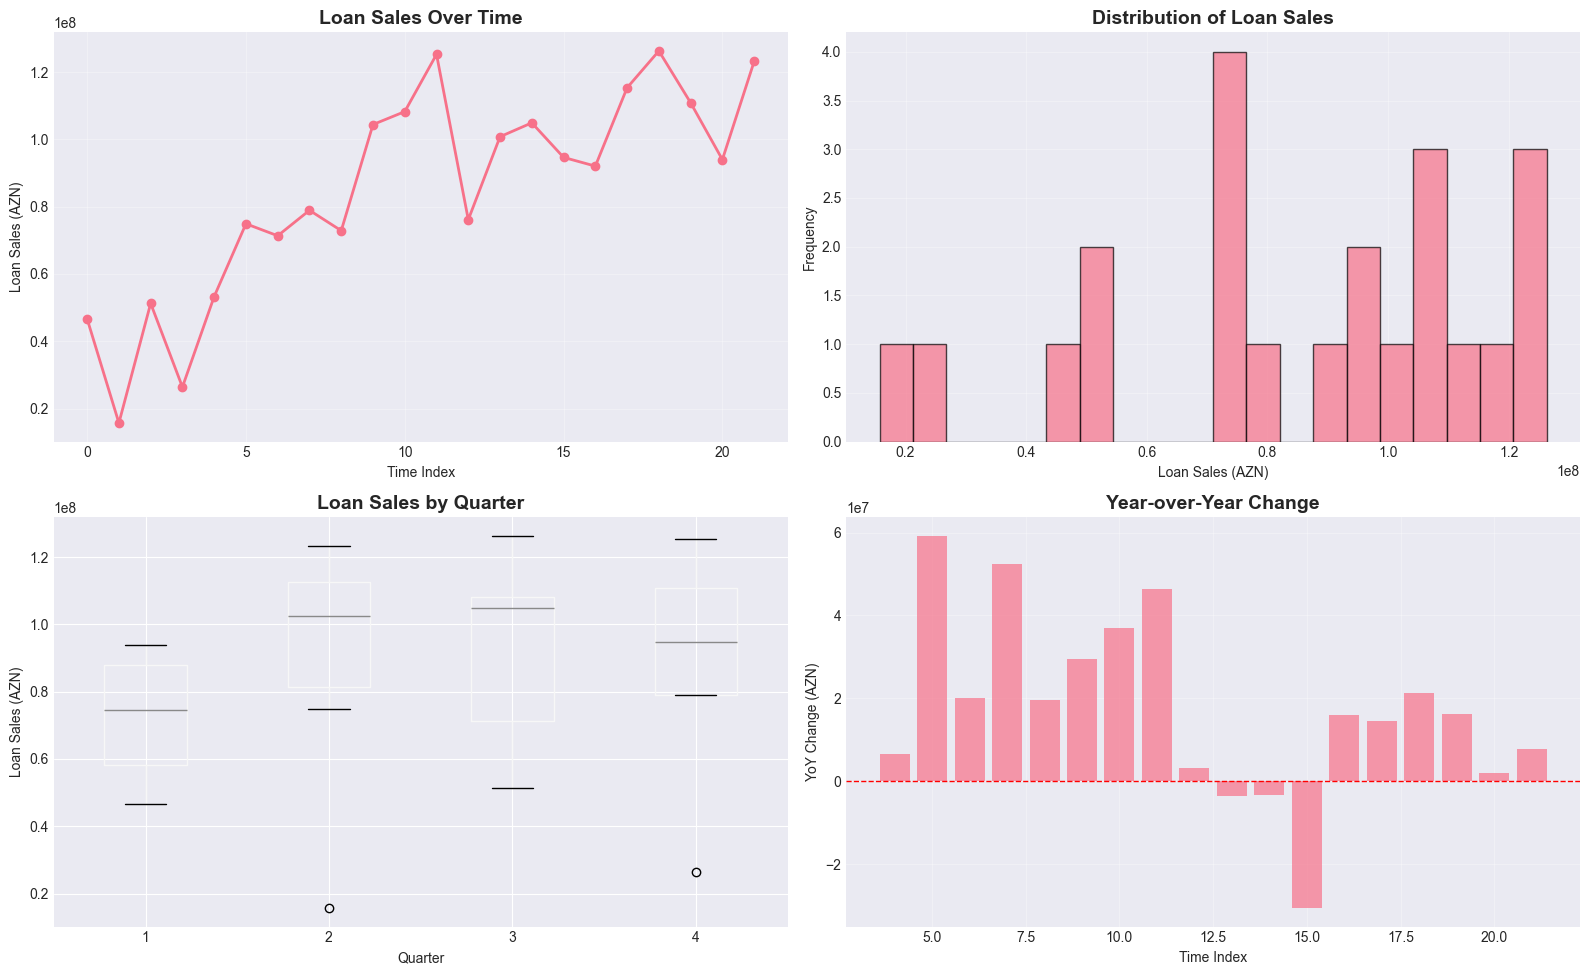


📊 Target Variable Statistics:
  Mean: 84,884,915.56 AZN
  Median: 93,016,444.91 AZN
  Std Dev: 31,290,413.62 AZN
  Min: 15,709,384.47 AZN
  Max: 126,285,413.80 AZN


In [14]:
# Plot target variable over time
if target_col in df.columns:
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    
    # Time series plot
    ax1 = axes[0, 0]
    df_valid = df[df[target_col].notna()]
    ax1.plot(df_valid['Time_Index'], df_valid[target_col], marker='o', linewidth=2, markersize=6)
    ax1.set_title('Loan Sales Over Time', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Time Index')
    ax1.set_ylabel('Loan Sales (AZN)')
    ax1.grid(True, alpha=0.3)
    
    # Distribution
    ax2 = axes[0, 1]
    ax2.hist(df_valid[target_col], bins=20, edgecolor='black', alpha=0.7)
    ax2.set_title('Distribution of Loan Sales', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Loan Sales (AZN)')
    ax2.set_ylabel('Frequency')
    ax2.grid(True, alpha=0.3)
    
    # Box plot by quarter
    ax3 = axes[1, 0]
    df_valid.boxplot(column=target_col, by='Quarter', ax=ax3)
    ax3.set_title('Loan Sales by Quarter', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Quarter')
    ax3.set_ylabel('Loan Sales (AZN)')
    plt.suptitle('')  # Remove auto-generated title
    
    # Year-over-year growth
    ax4 = axes[1, 1]
    if 'Diff_4' in df.columns:
        df_diff = df[df['Diff_4'].notna()]
        ax4.bar(df_diff['Time_Index'], df_diff['Diff_4'], alpha=0.7)
        ax4.axhline(y=0, color='red', linestyle='--', linewidth=1)
        ax4.set_title('Year-over-Year Change', fontsize=14, fontweight='bold')
        ax4.set_xlabel('Time Index')
        ax4.set_ylabel('YoY Change (AZN)')
        ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Summary statistics
    print("\n📊 Target Variable Statistics:")
    print(f"  Mean: {df_valid[target_col].mean():,.2f} AZN")
    print(f"  Median: {df_valid[target_col].median():,.2f} AZN")
    print(f"  Std Dev: {df_valid[target_col].std():,.2f} AZN")
    print(f"  Min: {df_valid[target_col].min():,.2f} AZN")
    print(f"  Max: {df_valid[target_col].max():,.2f} AZN")

## 8. Save Processed Data

In [15]:
# Save to both locations
print("💾 Saving processed data...\n")

# Save to notebooks/data (for ML training)
df.to_csv(PROCESSED_DATA_PATH, index=False)
print(f"✅ Saved to: {PROCESSED_DATA_PATH}")

# Save to dashboard public folder (for API)
df.to_csv(DASHBOARD_DATA_PATH, index=False)
print(f"✅ Saved to: {DASHBOARD_DATA_PATH}")

print(f"\n📊 Final Dataset:")
print(f"  Shape: {df.shape}")
print(f"  Rows: {df.shape[0]}")
print(f"  Columns: {df.shape[1]}")

💾 Saving processed data...

✅ Saved to: ../notebooks/data/ml_ready_data.csv
✅ Saved to: ../analytics-dashboard/public/data/ml_ready_data.csv

📊 Final Dataset:
  Shape: (23, 44)
  Rows: 23
  Columns: 44


In [16]:
# Display final column list
print("📋 Final Column List:\n")
for i, col in enumerate(df.columns, 1):
    print(f"{i:2d}. {col}")

📋 Final Column List:

 1. Rüblər
 2. GDP
 3. Dövlət_Gəlirləri
 4. Dövlət_Xərcləri 
 5. Əhalinin_nominal_gəlirləri
 6. Əhalinin_banklardakı_əmanətləri
 7. Orta_aylıq_əməkhaqqı
 8. Xarici_ticarət_dövriyyəsi
 9. İxrac
10. İdxal 
11. Pul_bazası
12. Oil_Price
13. Tikinti-quraşdırma_işlərinə_sərf_edilmiş_vəsait
14. İstehlak_xərcləri
15. Yaşayış_evlərinin_tikintisinə_yönəldilmiş_investisiyalar
16. Mənzil_qiymətləri
17. Uçot_faiz_dərəcəsi
18. Kumulyativ_satish
19. Nağd_pul_kredit_satışı
20. Portfel
21. NPLs
22. ROA 
23. ROE
24. Net_Interest_Margin
25. Efficiency_Ratio
26. Loan-to-Deposit_Ratio
27. Müştəri_sayı
28. Year
29. Quarter
30. Time_Index
31. Quarter_Sin
32. Quarter_Cos
33. Lag_1
34. Lag_2
35. Lag_3
36. Lag_4
37. Rolling_Mean_2
38. Rolling_Mean_3
39. Rolling_Mean_4
40. Rolling_Std_2
41. Rolling_Std_3
42. Rolling_Std_4
43. Diff_1
44. Diff_4


In [17]:
# Display sample of final data
print("📊 Sample of Processed Data:\n")
df.tail(10)

📊 Sample of Processed Data:



,Rüblər,GDP,Dövlət_Gəlirləri,Dövlət_Xərcləri,Əhalinin_nominal_gəlirləri,Əhalinin_banklardakı_əmanətləri,Orta_aylıq_əməkhaqqı,Xarici_ticarət_dövriyyəsi,İxrac,İdxal,Pul_bazası,Oil_Price,Tikinti-quraşdırma_işlərinə_sərf_edilmiş_vəsait,İstehlak_xərcləri,Yaşayış_evlərinin_tikintisinə_yönəldilmiş_investisiyalar,Mənzil_qiymətləri,Uçot_faiz_dərəcəsi,Kumulyativ_satish,Nağd_pul_kredit_satışı,Portfel,NPLs,ROA,ROE,Net_Interest_Margin,Efficiency_Ratio,Loan-to-Deposit_Ratio,Müştəri_sayı,Year,Quarter,Time_Index,Quarter_Sin,Quarter_Cos,Lag_1,Lag_2,Lag_3,Lag_4,Rolling_Mean_2,Rolling_Mean_3,Rolling_Mean_4,Rolling_Std_2,Rolling_Std_3,Rolling_Std_4,Diff_1,Diff_4
13,2023 II,29991500.00,7190000.00,7496300.00,19391200.00,12748800.00,0.92,18163480.00,11076860.00,7086620.00,18401700.00,0.13,3413103.60,0.34,213512.80,1.45,0.09,176926517.00,100794532.00,617854.07,16.58,0.02,0.13,0.03,0.66,1.26,76558.00,2023,2,13,0.00,-1.00,76131985.00,125262020.31,108253864.25,104410820.53,88463258.50,100729512.44,102610600.39,17439054.23,24565082.19,20407093.77,24662547.00,-3616288.53
14,2023 III,30510400.00,6597000.00,9151200.00,20147200.00,12705500.00,0.92,18084940.00,10578250.00,7506690.00,17896200.00,0.15,3196767.10,0.35,240258.20,1.49,0.09,281845104.42,104918587.42,643085.24,22.30,0.03,0.18,0.03,0.68,1.28,91918.00,2023,3,14,-1.00,-0.00,100794532.00,76131985.00,125262020.31,108253864.25,102856559.71,93948368.14,101776781.18,2916147.55,15566617.79,20166372.90,4124055.42,-3335276.83
15,2023 IV,32193000.00,13497800.00,13244000.00,20031900.00,12947800.00,0.93,19170220.00,11229350.00,7940870.00,20875200.00,0.14,5075198.40,0.35,332326.40,1.52,0.09,376492131.66,94647027.24,659043.32,17.30,0.03,0.18,0.03,0.73,1.16,108724.00,2023,4,15,-0.00,1.00,104918587.42,100794532.00,76131985.00,125262020.31,99782807.33,100120048.89,94123032.92,7263089.86,5168890.86,12714889.86,-10271560.18,-30614993.07
16,2024 I,29096800.00,9234300.00,8412600.00,19408100.00,13150500.00,0.99,16839350.00,10529630.00,6309720.00,20396400.00,0.14,2413844.60,0.35,233462.20,1.55,0.08,92049808.42,92049808.42,669359.79,16.43,0.00,0.02,0.02,0.75,1.07,139975.00,2024,1,16,1.00,0.00,94647027.24,104918587.42,100794532.00,76131985.00,93348417.83,97205141.03,98102488.77,1836511.04,6805095.73,5838991.10,-2597218.82,15917823.42
17,2024 II,30423600.00,9608600.00,7639500.00,20473100.00,14180700.00,1.00,20848290.00,12083770.00,8764520.00,20401000.00,0.14,2868130.70,0.35,630847.40,1.59,0.07,207387290.42,115337482.00,712667.61,16.23,0.01,0.08,0.03,0.75,1.13,198624.00,2024,2,17,0.00,-1.00,92049808.42,94647027.24,104918587.42,100794532.00,103693645.21,100678105.89,101738226.27,16466871.91,12761636.55,10633359.42,23287673.58,14542950.00
18,2024 III,33309100.00,8894100.00,9121900.00,21705800.00,14164000.00,0.99,20407990.00,10588790.00,9819200.00,20897400.00,0.14,3590035.80,0.36,800935.40,1.65,0.07,333672704.22,126285413.80,750604.13,20.05,0.02,0.13,0.03,0.73,1.21,224272.00,2024,3,18,-1.00,-0.00,115337482.00,92049808.42,94647027.24,104918587.42,120811447.90,111224234.74,107079932.87,7741356.82,17484515.18,16507769.88,10947931.80,21366826.38
19,2024 IV,33507500.00,9427200.00,12545700.00,21506400.00,14661900.00,1.01,22478250.00,11573090.00,10905160.00,20916500.00,0.13,5155278.90,0.36,907499.90,1.70,0.07,444555889.29,110883185.07,760424.19,17.58,0.03,0.17,0.03,0.73,1.19,250864.00,2024,4,19,-0.00,1.00,126285413.80,115337482.00,92049808.42,94647027.24,118584299.44,117502026.96,111138972.32,10891020.38,7925976.51,14277065.27,-15402228.73,16236157.83
20,2025 I,29892900.00,9733400.00,8115000.00,20690700.00,15074000.00,1.08,20325710.00,10698610.00,9627100.00,21498100.00,0.13,2344373.10,0.37,682931.60,1.78,0.07,93983081.41,93983081.41,777043.67,23.71,0.01,0.04,0.03,0.68,1.16,245777.00,2025,1,20,1.00,0.00,110883185.07,126285413.80,115337482.00,92049808.42,102433133.24,110383893.43,111622290.57,11950177.90,16156953.26,13422590.50,-16900103.66,1933272.99
21,2025 II,32185300.00,10070500.00,8980600.00,22057100.00,15437000.00,1.10,20413600.00,10

## 9. Data Summary Report

In [18]:
# Generate comprehensive summary
print("="*80)
print("DATA PREPARATION SUMMARY")
print("="*80)

print("\n📊 DATASET OVERVIEW:")
print(f"  Original Shape: {df_raw.shape}")
print(f"  Final Shape: {df.shape}")
print(f"  New Features Created: {df.shape[1] - df_raw.shape[1]}")

print("\n📅 TIME PERIOD:")
print(f"  Start: {df['Year'].min()}-Q{df['Quarter'].min()}")
print(f"  End: {df['Year'].max()}-Q{df['Quarter'].max()}")
print(f"  Total Quarters: {len(df[df['Year'].notna()])}")

print("\n📈 TARGET VARIABLE (Nağd_pul_kredit_satışı):")
if target_col in df.columns:
    valid_target = df[df[target_col].notna()][target_col]
    print(f"  Valid Records: {len(valid_target)}")
    print(f"  Mean: {valid_target.mean():,.2f} AZN")
    print(f"  Std Dev: {valid_target.std():,.2f} AZN")
    print(f"  Min: {valid_target.min():,.2f} AZN")
    print(f"  Max: {valid_target.max():,.2f} AZN")

print("\n🔧 FEATURE TYPES:")
print(f"  Original Features: {len(df_raw.columns)}")
print(f"  Time Features: 5 (Year, Quarter, Time_Index, Quarter_Sin, Quarter_Cos)")
print(f"  Lag Features: 4 (Lag_1 to Lag_4)")
print(f"  Rolling Features: 6 (Rolling means and stds)")
print(f"  Difference Features: 2 (Diff_1, Diff_4)")
print(f"  Total Features: {len(df.columns)}")

print("\n📁 FILES SAVED:")
print(f"  1. {PROCESSED_DATA_PATH}")
print(f"  2. {DASHBOARD_DATA_PATH}")

print("\n" + "="*80)
print("✅ DATA PREPARATION COMPLETE")
print("="*80)

DATA PREPARATION SUMMARY

📊 DATASET OVERVIEW:
  Original Shape: (23, 27)
  Final Shape: (23, 44)
  New Features Created: 17

📅 TIME PERIOD:
  Start: 2020-Q1
  End: 2025-Q4
  Total Quarters: 23

📈 TARGET VARIABLE (Nağd_pul_kredit_satışı):
  Valid Records: 22
  Mean: 84,884,915.56 AZN
  Std Dev: 31,290,413.62 AZN
  Min: 15,709,384.47 AZN
  Max: 126,285,413.80 AZN

🔧 FEATURE TYPES:
  Original Features: 27
  Time Features: 5 (Year, Quarter, Time_Index, Quarter_Sin, Quarter_Cos)
  Lag Features: 4 (Lag_1 to Lag_4)
  Rolling Features: 6 (Rolling means and stds)
  Difference Features: 2 (Diff_1, Diff_4)
  Total Features: 44

📁 FILES SAVED:
  1. ../notebooks/data/ml_ready_data.csv
  2. ../analytics-dashboard/public/data/ml_ready_data.csv

✅ DATA PREPARATION COMPLETE
